In [9]:
from __future__ import print_function
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.9145, 0.0161, 0.4657],
        [0.6188, 0.9560, 0.0398],
        [0.1651, 0.1280, 0.9610],
        [0.1256, 0.4073, 0.8048],
        [0.7427, 0.2583, 0.0922]])


In [10]:
import scipy.io.wavfile
import soundfile as sf

In [11]:
fpath='/baie/corpus/DELIPS/wav_tous_phonemes_nccfr/03_12_07_nb1_1_16/a/03_12_07_nb1_1_16_a_._._11697.wav'
[fs,signal]=scipy.io.wavfile.read(fpath)

In [12]:
fs, signal[:10]

(16000, array([   2,   -2,   10,   28,   23,  -18,  -44,  -87, -101,  -85],
       dtype=int16))

In [18]:
# int16 ---> 65536 
# signed int16 --> divide by 32768 to get floats between [-1, 1] 
signal=signal.astype(float)/32768

In [20]:
min(signal), max(signal)

(-0.009735107421875, 0.024322509765625)

In [23]:
[signal,fs]=sf.read(fpath)

In [24]:
fs, signal[:10]

(16000,
 array([ 6.10351562e-05, -6.10351562e-05,  3.05175781e-04,  8.54492188e-04,
         7.01904297e-04, -5.49316406e-04, -1.34277344e-03, -2.65502930e-03,
        -3.08227539e-03, -2.59399414e-03]))

In [25]:
min(signal), max(signal)

(-0.009735107421875, 0.024322509765625)

In [49]:
from __future__ import print_function, division
import os
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import soundfile as sf

from data_io import ReadList,read_conf,str_to_bool

import matplotlib.pyplot as plt

# # Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

In [61]:
class NCCFRDataset(Dataset):
    """
    Loader for NCCFR phone speech data and labels
    """
    def __init__(self, scp_fpath, wavdir, fs, cw_len, cw_shift, fact_amp, lab_dict_fpath, lab2_dict_fpath=None, 
                 doNormalize=False):
        
        # class1toclass2_dict_fpath=None, 
        
        # wav list
        self.wav_lst = ReadList(scp_fpath)
        self.data_folder = wavdir

        self.fs = fs
        # Converting context and shift in samples
        self.wlen = int(fs * cw_len / 1000.00)
        self.wshift = int(fs * cw_shift / 1000.00)
        self.fact_amp = fact_amp
        self.doNormalize = doNormalize
        
        self.lab_dict=np.load(lab_dict_fpath).item()

        if not lab2_dict_fpath is None:
            self.lab2_dict = np.load(lab2_dict_fpath).item()
        else: self.lab2_dict = None
            
#         if not class1toclass2_dict_fpath is None:
#             class1toclass2_dict = np.load(class1toclass2_dict_fpath).item()
#             self.M_class1_to_class2 = class1toclass2_dict['M']
#         else:
#             self.M_class1_to_class2 = None


    def __len__(self):
        return len(self.wav_lst)


    def __getitem__(self, index):

        # sf.read returns floats between [-1, 1]
        # if one uses scipy.io.wavfile.read, we get signed int6 ---> need to divide signal by 65536/2=32768
        [signal, _] = sf.read(self.data_folder + self.wav_lst[index])

        # normalize signal
        if self.doNormalize:
            signal = signal / np.abs(np.max(signal))

        # accessing to a random chunk
        snt_len = signal.shape[0]
        snt_beg = np.random.randint(snt_len - self.wlen - 1)  # randint(0, snt_len-2*wlen-1)
        snt_end = snt_beg + self.wlen
        rand_amp_arr = np.random.uniform(1.0-self.fact_amp, 1+self.fact_amp, 1)

        sample = {'feat': signal[snt_beg:snt_end] * rand_amp_arr, 'lab': self.lab_dict[self.wav_lst[index]]}

        if not self.lab2_dict is None:
            sample = {'feat': signal[snt_beg:snt_end] * rand_amp_arr,
                      'lab': self.lab_dict[self.wav_lst[index]],
                    'lab2': self.lab2_dict[self.wav_lst[index]]}

        # if self.transform:
        #     sample = self.transform(sample)

        return sample


In [68]:
def unit_test():
    # Reading cfg file
#     options = read_conf()

    # [data]
    tr_lst = '../keras-sincnet/NCCFR/NCCFR_train_tous_phonemes.scp'
    lab_dict_fpath = '../keras-sincnet/NCCFR/NCCFR_tous_phonemes_labels.npy'
    lab2_dict_fpath = '../keras-sincnet/NCCFR/NCCFR_tous_phonemes_hyperlevel3_labels.npy'
#     class1toclass2_dict_fpath =  '../keras-sincnet/NCCFR/NCCFR_tous_phonemes_hyperlevel3_M.npy'
    data_folder = '/baie/corpus/DELIPS/wav_tous_phonemes_nccfr/'

    # [windowing]
    fs = 16000
    cw_len = 25
    cw_shift = 5
    fact_amp = 0.2

    train_dataset = NCCFRDataset(scp_fpath=tr_lst,
                                 wavdir=data_folder,
                                 fs=fs,
                                 cw_len=cw_len,
                                 cw_shift=cw_shift,
                                 fact_amp=fact_amp,
                                 lab_dict_fpath=lab_dict_fpath,
                                 lab2_dict_fpath=lab2_dict_fpath,
                                 doNormalize=True)

    for i in range(len(train_dataset)):
        sample = train_dataset[i]

#         print(i, sample)
        print(i, sample['feat'].shape, sample['lab'], sample['lab2'])
        
        plt.subplot(4,1,i+1)
        plt.plot(sample['feat'])
        
        if i == 3:
            break
    plt.tight_layout()
#     plt.savefig('unit_test_nccfr.png')

0 (400,) 15 1
1 (400,) 15 1
2 (400,) 15 1
3 (400,) 15 1


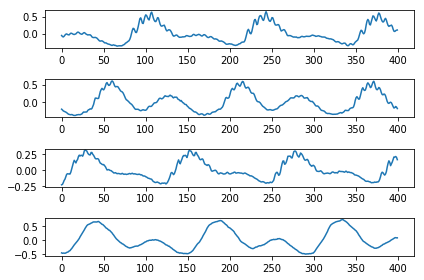

In [69]:
unit_test()

In [91]:
def unit_test_dataloa():
    # Reading cfg file
#     options = read_conf()

    # [data]
    tr_lst = '../keras-sincnet/NCCFR/NCCFR_train_tous_phonemes.scp'
    lab_dict_fpath = '../keras-sincnet/NCCFR/NCCFR_tous_phonemes_labels.npy'
    lab2_dict_fpath = '../keras-sincnet/NCCFR/NCCFR_tous_phonemes_hyperlevel3_labels.npy'
#     class1toclass2_dict_fpath =  '../keras-sincnet/NCCFR/NCCFR_tous_phonemes_hyperlevel3_M.npy'
    data_folder = '/baie/corpus/DELIPS/wav_tous_phonemes_nccfr/'

    # [windowing]
    fs = 16000
    cw_len = 25
    cw_shift = 5
    fact_amp = 0.2

    train_dataset = NCCFRDataset(scp_fpath=tr_lst,
                                 wavdir=data_folder,
                                 fs=fs,
                                 cw_len=cw_len,
                                 cw_shift=cw_shift,
                                 fact_amp=fact_amp,
                                 lab_dict_fpath=lab_dict_fpath,
                                 lab2_dict_fpath=lab2_dict_fpath,
                                 doNormalize=True)

    
    shuffle=False
    dataloader = DataLoader(train_dataset, batch_size=4,
                            shuffle=shuffle, num_workers=4)
    
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['feat'].size(),
          sample_batched['lab'].size(),
             sample_batched['lab2'].size())

        plt.subplot(4,1,i_batch+1)
        plt.plot(sample_batched['feat'][0].numpy())
        plt.title('lab: %d --- lab2: %d'%(sample_batched['lab'][0].numpy(), sample_batched['lab2'][0].numpy()))
        
        if i_batch == 3:
            break
    plt.tight_layout()
#     plt.savefig('unit_test2_nccfr.png')

0 torch.Size([4, 400]) torch.Size([4]) torch.Size([4])
1 torch.Size([4, 400]) torch.Size([4]) torch.Size([4])
2 torch.Size([4, 400]) torch.Size([4]) torch.Size([4])
3 torch.Size([4, 400]) torch.Size([4]) torch.Size([4])


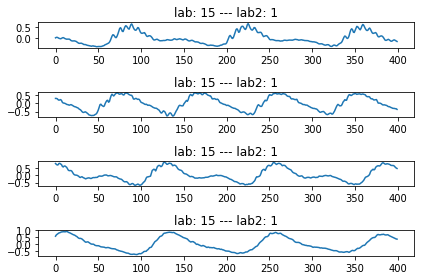

In [93]:
unit_test_dataloa()